#**체인 기초**

In [ ]:
from dotenv import load_dotenv
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain_openai import ChatOpenAI

load_dotenv()

# ChatOpenAI 모델 호출 (재표 선배가 gpt-4o 쓰면 부자라 해서 3.5 turbo로 바꿨습니다.)
model = ChatOpenAI(model="gpt-3.5-turbo")

# 프롬프트 형식 정의하기
prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", "넌 {topic}에 대해 농담을 던지는 코미디언이야."),
        ("human", "{joke_count}개의 농담을 해봐"),
    ]
)

# LangChain Expression Language (LCEL) 사용해서 합쳐진 체인 생성
chain = prompt_template | model | StrOutputParser()
# chain = prompt_template | model

# 체인 실행
result = chain.invoke({"topic": "변호사", "joke_count": 3})

# 결과
print(result)


실행 결과:

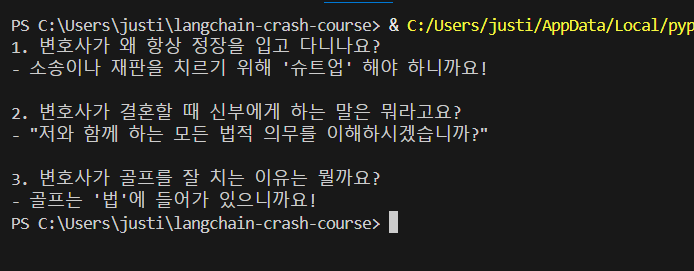

#**랭체인이 동작하는 방식**

In [ ]:
from dotenv import load_dotenv
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnableLambda, RunnableSequence
from langchain_openai import ChatOpenAI

load_dotenv()

model = ChatOpenAI(model="gpt-3.5-turbo")

# 프롬프트 형식 정의하기
prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", "넌 {topic}에 대해 농담을 던지는 코미디언이야."),
        ("human", "{joke_count}개의 농담을 해봐"),
    ]
)

# 개별의 실행 가능한(Runnable) 체인 생성하기
format_prompt = RunnableLambda(lambda x: prompt_template.format_prompt(**x))
invoke_model = RunnableLambda(lambda x: model.invoke(x.to_messages()))
parse_output = RunnableLambda(lambda x: x.content)

# RunnableSequence 체인 생성하기 (일전의 LCEL 체인과 같음)
chain = RunnableSequence(first=format_prompt, middle=[invoke_model], last=parse_output)

response = chain.invoke({"topic": "고양이", "joke_count": 3})

print(response)


실행 결과:

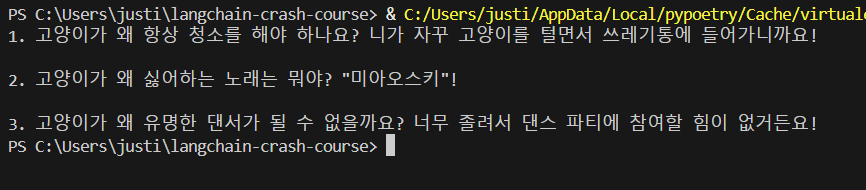

#**확장된 기능의 체인**

In [ ]:
from dotenv import load_dotenv
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnableLambda
from langchain_openai import ChatOpenAI

load_dotenv()

model = ChatOpenAI(model="gpt-3.5-turbo")

prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", "{topic}이 어떻게 생겼는지 묘사해줘."),
        ("human", "{describe_count}가지 경우로 묘사해봐."),
    ]
)

''' 영어 버전 템플릿(uppercase_output 기능을 사용하기 위해)
prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", "Describe what {topic} looks like."),
        ("human", "Describe {describe_count} cases."),
    ]
)
'''

# RunnableLambda 사용해서 부가적인 처리 과정 정의하기
uppercase_output = RunnableLambda(lambda x: x.upper())
count_words = RunnableLambda(lambda x: f"Word count: {len(x.split())}\n{x}")

# LangChain Expression Language (LCEL) 사용해서 합쳐진 체인 만들기
chain = prompt_template | model | StrOutputParser() | uppercase_output | count_words

result = chain.invoke({"topic": "고양이", "describe_count": 3})

print(result)


실행 결과:
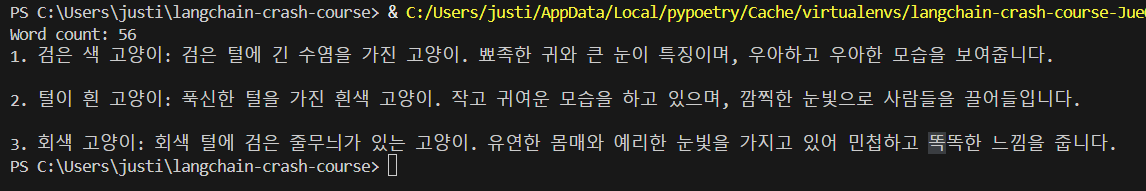

영어 실행 결과(uppercase_output 기능 사용하기 위해):
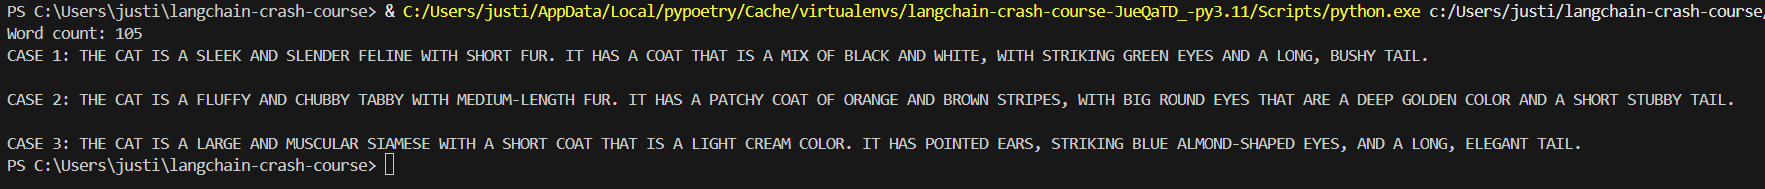

#**병렬 체인**

In [ ]:
from dotenv import load_dotenv
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnableParallel, RunnableLambda
from langchain_openai import ChatOpenAI

load_dotenv()

model = ChatOpenAI(model="gpt-3.5-turbo")

prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", "넌 아주 전문적인 제품 평가사야."),
        ("human", "{product_name} 제품의 주요 기능을 열거해줘."),
    ]
)


# 장점 분석 과정 정의
def analyze_pros(features):
    pros_template = ChatPromptTemplate.from_messages(
        [
            ("system", "넌 아주 전문적인 제품 평가사야."),
            (
                "human",
                "다음 기능들을 고려하여: {features}, 이 기능들의 장점을 나열해줘.",
            ),
        ]
    )
    return pros_template.format_prompt(features=features)


# 단점 분석 과정 정의
def analyze_cons(features):
    cons_template = ChatPromptTemplate.from_messages(
        [
            ("system", "넌 아주 전문적인 제품 평가사야."),
            (
                "human",
                "다음 기능들을 고려하여: {features}, 이 기능들의 단점을 나열해줘.",
            ),
        ]
    )
    return cons_template.format_prompt(features=features)


# 최종 평가에 장단점 결과 합치기
def combine_pros_cons(pros, cons):
    return f"장점:\n{pros}\n\n단점:\n{cons}"


# LCEL로 분기점 만들기
pros_branch_chain = (
    RunnableLambda(lambda x: analyze_pros(x)) | model | StrOutputParser()
)

cons_branch_chain = (
    RunnableLambda(lambda x: analyze_cons(x)) | model | StrOutputParser()
)

chain = (
    prompt_template
    | model
    | StrOutputParser()
    | RunnableParallel(branches={"pros": pros_branch_chain, "cons": cons_branch_chain})
    | RunnableLambda(lambda x: combine_pros_cons(x["branches"]["pros"], x["branches"]["cons"]))
)

result = chain.invoke({"product_name": "날이 시퍼렇게 선 장미칼"})

print(result)


실행 결과:
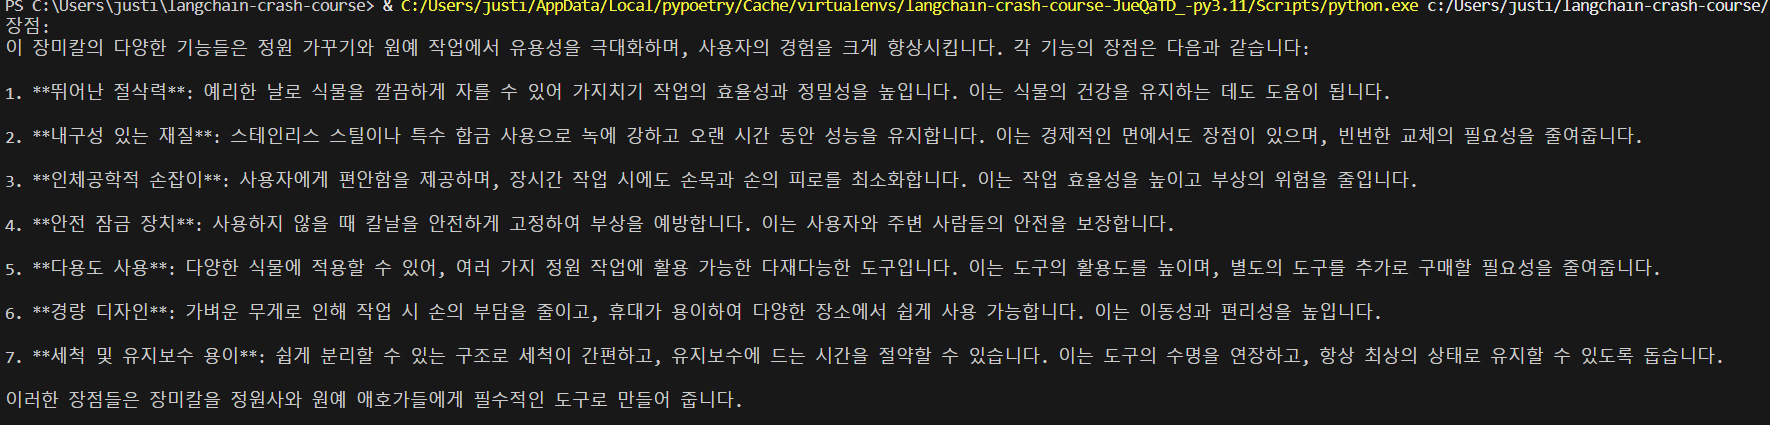
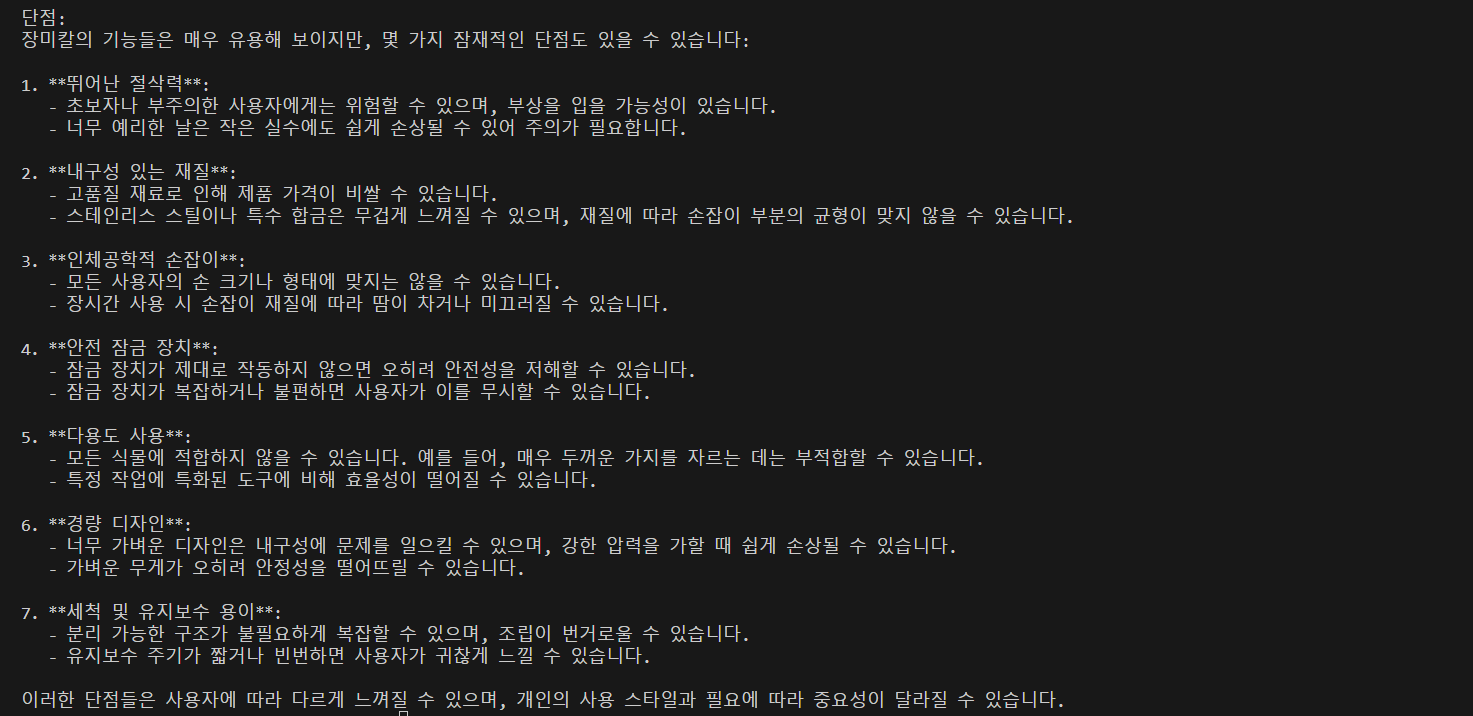

#**랭체인 나무**

In [ ]:
from dotenv import load_dotenv
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnableBranch
from langchain_openai import ChatOpenAI

load_dotenv()

model = ChatOpenAI(model="gpt-4o")

# 다른 피드백 유행에 따른 프롬프트 형식 정의하기
positive_feedback_template = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant."),
        ("human",
         "Generate a thank you note for this positive feedback: {feedback}."),
    ]
)

negative_feedback_template = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant."),
        ("human",
         "Generate a response addressing this negative feedback: {feedback}."),
    ]
)

neutral_feedback_template = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant."),
        (
            "human",
            "Generate a request for more details for this neutral feedback: {feedback}.",
        ),
    ]
)

escalate_feedback_template = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant."),
        (
            "human",
            "Generate a message to escalate this feedback to a human agent: {feedback}.",
        ),
    ]
)

# 피드백 분류(긍정적, 부정적, 중립) 템플릿 정의
classification_template = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant."),
        ("human",
         "Classify the sentiment of this feedback as positive, negative, neutral, or escalate: {feedback}."),
    ]
)

# 피드백 다루기 위한 분기점 정의하기
branches = RunnableBranch(
    (
        lambda x: "positive" in x,
        positive_feedback_template | model | StrOutputParser()  # 긍정적 피드백 체인
    ),
    (
        lambda x: "negative" in x,
        negative_feedback_template | model | StrOutputParser()  # 부정적 피드백 체인
    ),
    (
        lambda x: "neutral" in x,
        neutral_feedback_template | model | StrOutputParser()  # 중립 피드백 체인
    ),
    escalate_feedback_template | model | StrOutputParser()
)

# 분류 체인 만들기
classification_chain = classification_template | model | StrOutputParser()

# 분류 & 응답 생성 체인 병합
chain = classification_chain | branches

# 예시 리뷰로 실행시키기
# Good review - "The product is excellent. I really enjoyed using it and found it very helpful."
# Bad review - "The product is terrible. It broke after just one use and the quality is very poor."
# Neutral review - "The product is okay. It works as expected but nothing exceptional."
# Default - "I'm not sure about the product yet. Can you tell me more about its features and benefits?"

review = "The product is terrible. It broke after just one use and the quality is very poor."
result = chain.invoke({"feedback": review})

# Output the result
print(result)


부정적 리뷰 실행 결과:

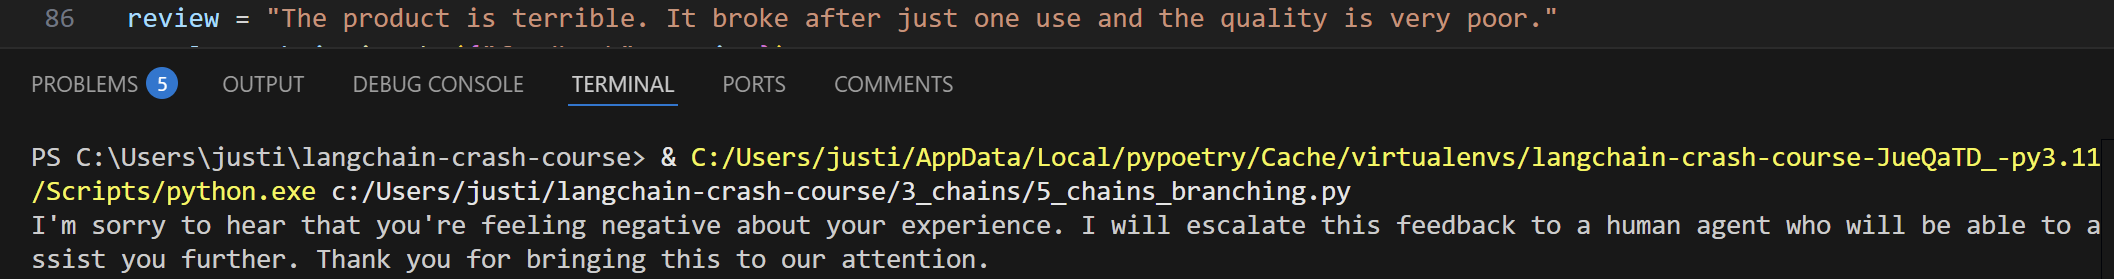

긍정적 리뷰 실행 결과:

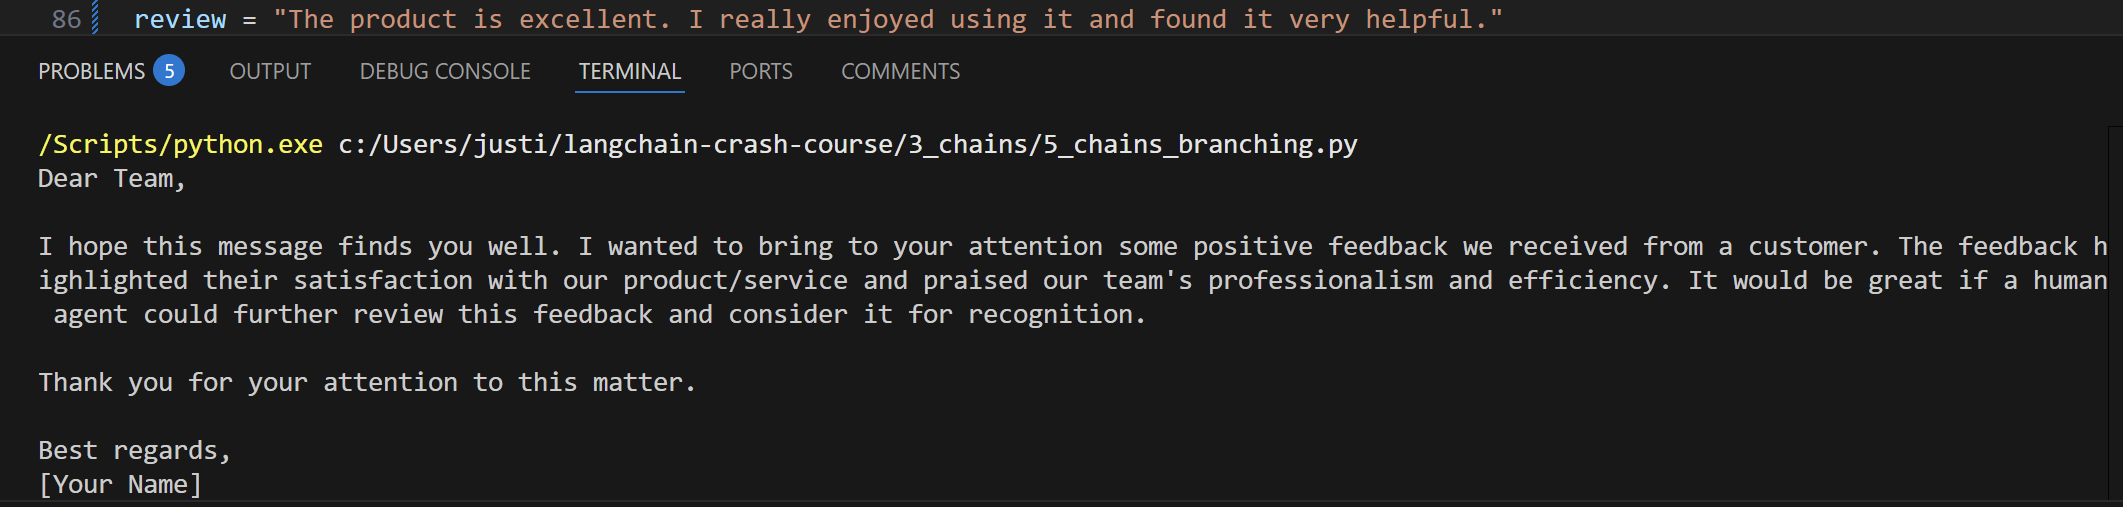

중립 리뷰 실행 결과:

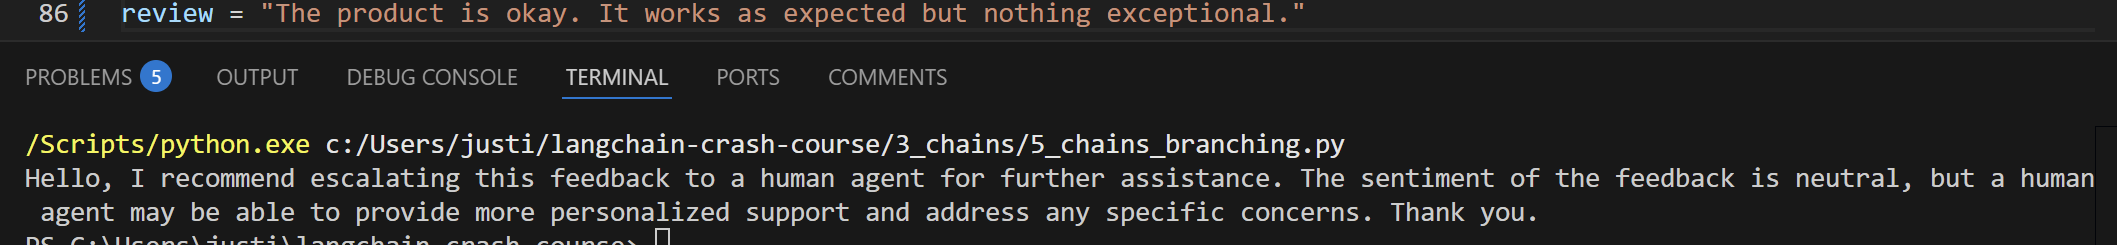